In [1]:
##----Import packages and define visualization functions

import numpy as np
from matplotlib import pyplot as plt
from tifffile import imsave
from tqdm import tqdm
from skimage import morphology,measure,filters
from math import ceil
from scipy import ndimage as ndi
import os
from skimage.morphology import ball
import h5py as h5

def image_show(image, nrows=1, ncols=1, cmap='gray',size = 8):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    
    plt.show();
    return fig, ax

def vimg_show(volume):
    image_show(volume[volume.shape[0]//2])

In [2]:
##----Define directory of image stack to be processed

# Define folder for saving output
save_path = 'V:\\Weisi\\cubic_brain_1_lowres_1_13_22\\vessel_seg'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# Raw h5 data directory
filedir = os.path.join(os.path.dirname(save_path),'ROI1000_4900_-2500_5800.h5') # the image format is h5

# Select channels from hiearchical h5 file
ch = 't00000/s00/0/cells' #use 0th channel at 0th downsample level as original dataset
ch_ds = 't00000/s00/2/cells' #use 2nd downsample channel as the downsample dataset

In [4]:
##----Sliding box parameter initialization

# Define sliding box size and step sizes
cube_size = 300
ovlp_size = cube_size//10 #50
step_size = cube_size - ovlp_size

with h5.File(filedir, 'r') as f:
    image_3d = f[ch]
    h,w,d = image_3d.shape

# Calculate number of boxes based on box size and step size on 3 dimensions
num_pos_h = ceil((h+1-cube_size)/step_size) 
num_pos_w = ceil((w+1-cube_size)/step_size)
num_pos_d = ceil((d+1-cube_size)/step_size)
    
print('num of steps in 3 dims (including step 0):', num_pos_h, num_pos_w, num_pos_d)

# Initialize arrays for sliding box computation
otsu_3d = np.zeros((h,w,d), dtype = np.uint8)
count_3d = np.zeros((h,w,d), dtype = np.uint8)

print(otsu_3d.shape)

num of steps in 3 dims (including step 0): 3 3 3
(1000, 1000, 1000)


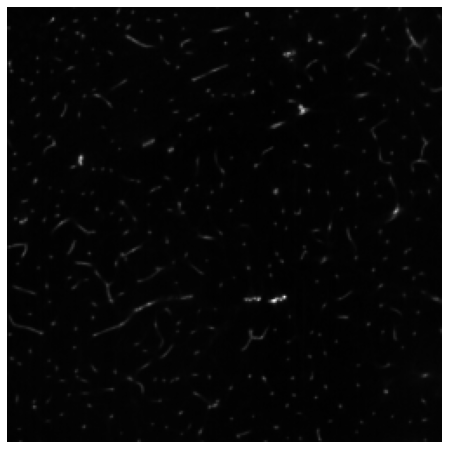

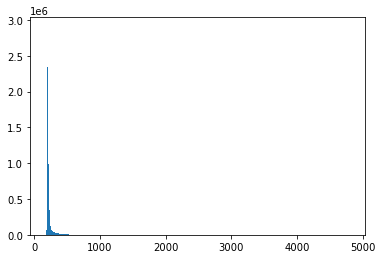

ds_stack.dtype uint16
np.amin 169
np.amax 4804
hi_val: 927
background 139.04999999999998
stack_norm.shape (250, 250, 250)
np.amax 255
dtype uint8


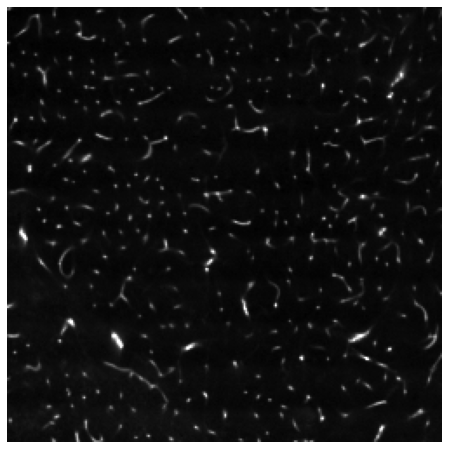

In [5]:
##----Define functions for data normalization

def i16_2_u16(data): # for this dataset, the dynamic range below 0 is discarded
    return np.uint16(np.clip(data, 0, 65535)) #just clip at 0
    
with h5.File(filedir, 'r') as f:
    ds_stack = i16_2_u16(f[ch_ds][:,:,:]) #use down-sampled image to find parameters

image_show(ds_stack[:,ds_stack.shape[1]//2,:]) #show center slice

# Visualize intensity distribution
plt.hist(ds_stack.flatten(), 1000)
plt.show()

# Define data normalization parameters
hist_clip = 0.999
foreground_vals = np.sort(ds_stack,axis=None)
hi_val = foreground_vals[int(np.round(len(foreground_vals)*hist_clip))] #histogram 99.9%
background = hi_val*0.15

print('ds_stack.dtype', ds_stack.dtype) #uint16 in h5 file
print('np.amin', np.amin(ds_stack))
print('np.amax', np.amax(ds_stack))
print('hi_val:', hi_val)
print('background', background)

# Define function to convert from uint16 to uint8 with normalization (call this for each sub-block)
def norm_uint8(stack, background, hi_val): #!!!stack has to be uint16 format to use this
    #convert uint16 to uint8
    stack_norm = np.clip(stack, background, hi_val) - background
    stack_norm = stack_norm.astype(float) / (hi_val-background) *255
    stack_norm = stack_norm.astype(np.uint8)

    print('stack_norm.shape', stack_norm.shape)
    print('np.amax', np.amax(stack_norm))
    print('dtype', stack_norm.dtype)

    return stack_norm

  0%|          | 0/4 [00:00<?, ?it/s]

stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 190)
np.amax 255
dtype uint8


 25%|██▌       | 1/4 [02:04<06:14, 124.75s/it]

stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 190)
np.amax 255
dtype uint8


 50%|█████     | 2/4 [04:09<04:09, 124.68s/it]

stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (300, 190, 190)
np.amax 255
dtype uint8


 75%|███████▌  | 3/4 [06:14<02:04, 124.74s/it]

stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 300, 190)
np.amax 255
dtype uint8
stack_norm.shape (190, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 190, 300)
np.amax 255
dtype uint8
stack_norm.shape (190, 190, 190)
np.amax 255
dtype uint8


100%|██████████| 4/4 [07:58<00:00, 119.56s/it]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
[1 2 4 8]
[0 1 2 3 4]


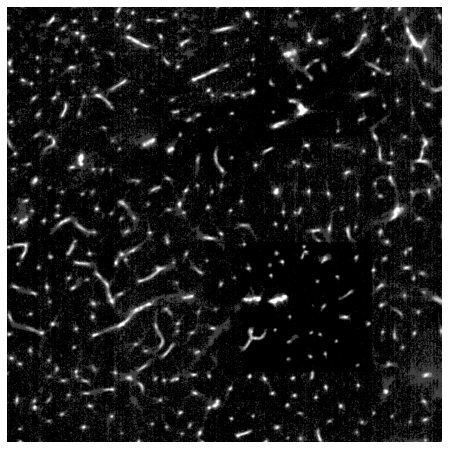

In [6]:
##----Actual processing for localized multi-otsu thresholding with sliding boxes

# go through all the overlapping regions
for pos_h in tqdm(range(0, int(num_pos_h*(step_size+1)), step_size)):
    for pos_w in range(0, int(num_pos_w*(step_size+1)), step_size):
        for pos_d in range(0, int(num_pos_d*(step_size+1)), step_size):
            
            # Get the current cube at each box location
            with h5.File(filedir, 'r') as f: #only read sub-block
                cur_cube = f[ch][pos_h:min(h, pos_h+cube_size), pos_w:min(w, pos_w+cube_size), pos_d:min(d, pos_d+cube_size)]
            
            # Normalize and convert to uint8
            cur_cube = norm_uint8(i16_2_u16(cur_cube), background, hi_val)

            # Calculate threshold within this cube
            thresh = filters.threshold_multiotsu(cur_cube, classes=5) #thresdhold into 5 classes
            
            # Multi-thredholding on 3D cube
            cur_otsu_3d_ROI = (np.digitize(cur_cube, thresh)).astype(np.uint8)
            
            # Put the thresholded image back to its location on the entire 3D image 
            # and preprare for average otsu thresdhold over overlapping region
            otsu_3d[pos_h:min(h, pos_h+cube_size), pos_w:min(w, pos_w+cube_size), pos_d:min(d, pos_d+cube_size)] += cur_otsu_3d_ROI
            count_3d[pos_h:min(h, pos_h+cube_size), pos_w:min(w, pos_w+cube_size), pos_d:min(d, pos_d+cube_size)] += np.ones(cur_otsu_3d_ROI.shape, dtype = np.uint8)

print(np.unique(otsu_3d))
print(np.unique(count_3d))

# Average Otsu thresdhold in the overlapping region
otsu_3d = (np.divide(otsu_3d, count_3d)).astype(np.uint8) #average from all thresholds
print(np.unique(otsu_3d))

#save multi-ostu results
image_show(otsu_3d[:, otsu_3d.shape[1]//2, :])
imsave(save_path +'//multiotsuthrsh.tif',otsu_3d)

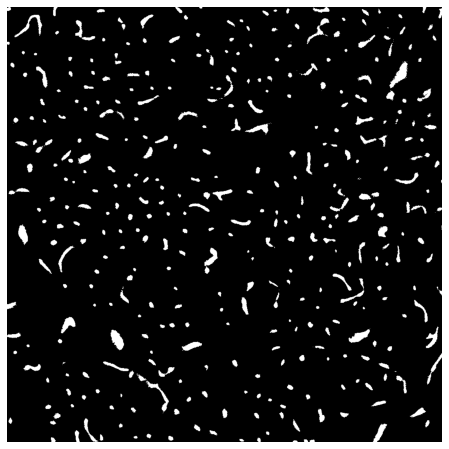

In [7]:
##----Hysteresis thresholding based on multi-otsu results

lowt = 1 # >lowt is gray region (1 and lower is background)
hight = 2 # >hight is white region (3 and higher is foreground)
#effectively: 2 is the "gray" level

# Hysteresis thresholding (to mitigate non-uniform staining):
# finds regions where ``image`` is greater than ``high``
# OR ``image`` is greater than ``low`` *and* that region is connected to a region greater than ``high``.
hyst = filters.apply_hysteresis_threshold(otsu_3d, lowt, hight) 
hyst = hyst.astype(np.uint8)*255

# Save hysterisis binary thresholding results
image_show(hyst[hyst.shape[0]//2])
imsave(save_path +'//hyst_thrsh.tif',hyst)

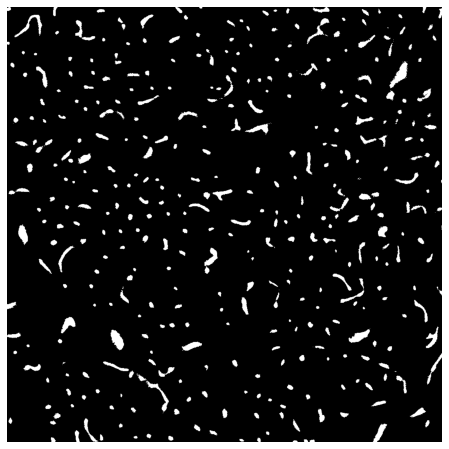

In [9]:
##----Noise removal of hysterisis thresholding
hyst_adj = ndi.morphology.binary_opening(hyst, structure = ball(1)) #opening
hyst_adj = morphology.remove_small_objects(hyst, 50).astype(np.uint8)*255 #remove obj smaller than 50 voxels
image_show(hyst_adj[hyst_adj.shape[0]//2])
imsave(save_path +'//hyst_adj.tif',hyst_adj) #save results

100%|██████████| 1000/1000 [00:30<00:00, 32.46it/s]


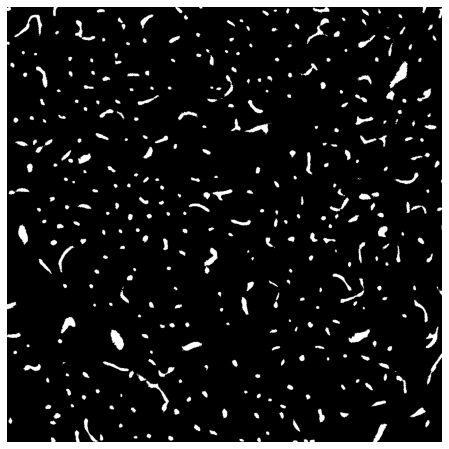

In [17]:
##---Fill hole + remove small object (from top)
fill_hole1 = np.zeros(hyst_adj.shape,dtype = np.uint8)
for frame_idx in tqdm(range(hyst_adj.shape[0])):
    fill_hole = ndi.morphology.binary_fill_holes(hyst_adj[frame_idx,:,:]).astype(np.uint8)
    fill_hole1[frame_idx] = fill_hole
    
fill_hole1 = (fill_hole1*255).astype(np.uint8)
image_show(fill_hole1[fill_hole1.shape[0]//2])
imsave(save_path +'//fill_hole1.tif',fill_hole1)

In [18]:
##----Charaterize connectivity
labels = measure.label(fill_hole1, background=0)
print('number of objects:', labels.max())

number of objects: 138


In [19]:
##----Find the biggest connected object in the binary mask
num_obj = labels.max()
size_list = []
for i in tqdm(range(1, num_obj+1)):
    obj_size = np.count_nonzero(labels[labels==i])
    size_list.append((i, obj_size))

size_list.sort(key = lambda x: x[1], reverse=True) #descending order
print(size_list[:50O) #show the biggest 50 objects

# Obvservation: there is one super big connected vasculature object. 
# Other minor objects are smaller by many orders and therefor can be neglected.

100%|██████████| 138/138 [03:19<00:00,  1.45s/it]

[(1, 54262175), (11, 22351), (63, 21147), (34, 15893), (51, 12958), (57, 11426), (67, 11276), (44, 11215), (45, 9857), (30, 9243), (19, 8129), (56, 7269), (96, 6560), (74, 6282), (75, 5941), (92, 5907), (64, 5846), (112, 5739), (94, 4951), (15, 4903), (68, 4020), (6, 3732), (100, 3687), (114, 3686), (29, 3447), (47, 3395), (16, 3367), (10, 2938), (21, 2914), (110, 2762), (17, 2721), (101, 2604), (46, 2552), (123, 2474), (106, 2448), (54, 2414), (76, 2380), (43, 2340), (66, 2337), (8, 2177), (78, 1959), (86, 1937), (127, 1931), (113, 1897), (119, 1883), (118, 1801), (5, 1772), (35, 1770), (55, 1684), (65, 1675)]


In [20]:
#----Save only the biggest object as segmentation results

largest_obj_idx = size_list[0][0]
largest_obj = np.zeros(labels.shape, dtype = np.uint8)
largest_obj[labels==largest_obj_idx] = 255

imsave(save_path +'//largest_obj.tif',largest_obj)